Import

In [1]:
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature

In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

In [3]:
# ========== Dataset from Drive ==========
# from google.colab import drive
# drive.mount('/data/data')

Classes

In [4]:
import os
for dir, sub_dirs, _ in os.walk("./data"):
    class_names = sub_dirs
    break

json.dump({"classes": class_names}, open("classes.json", "w"))
n_classes = len(class_names)
class_names

['Amanita_Caesarea-Edible',
 'Amanita_Citrina-Edible',
 'Amanita_Pantherina-NotEdible',
 'Boletus_Regius-Edible',
 'Clitocybe_Costata-Edible',
 'Entoloma_Lividum-NotEdible',
 'Gyromitra_Esculenta-NotEdible',
 'Helvella_Crispa-Edible',
 'Hydnum_Rufescens-NotEdible',
 'Hygrophorus_Latitabundus-Edible',
 'Morchella_Deliciosa-Edible',
 'Omphalotus_Olearius-NotEdible',
 'Phallus_Impudicus-NotEdible',
 'Rubroboletus_Satanas-NotEdible',
 'Russula_Cyanoxantha-Edible',
 'Russula_Delica-NotEdible',
 'Unknown-NA']

In [5]:
# ========== Dataset loading ==============

directory = "./data"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=48,
    image_size=(128, 128),
    shuffle=True,
    seed=120,
    validation_split=0.30,
    subset="training",
    verbose=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=48,
    image_size=(128, 128),
    shuffle=True,
    seed=120,
    validation_split=0.30,
    subset="validation",
    verbose=True)

# ========== Data Preprocessing ==============
def image_rescaling(img, y):
    img = img * (1./255)
    return img, y

def onehot_encode(img, y):
    y = tf.one_hot(y, n_classes)
    return img, y


train_dataset = train_dataset.map(image_rescaling)
train_dataset = train_dataset.map(onehot_encode)

validation_dataset = validation_dataset.map(image_rescaling)
validation_dataset = validation_dataset.map(onehot_encode)

# =========== Prefetchig to efficiently load the dataset in memory =========
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE) 


Found 6017 files belonging to 17 classes.
Using 4212 files for training.
Found 6017 files belonging to 17 classes.
Using 1805 files for validation.


img: AxesImage(shape=(128, 128, 3))
target: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(17,), dtype=float32)


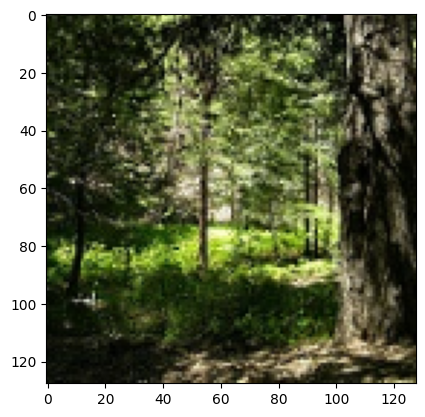

In [6]:
for img, y in train_dataset:
    print("img:", plt.imshow(img[0].numpy()))
    print("target:",y[0])
    break
plt.show()

#### Modelling

In [9]:
def get_model():
    # Input Layer
    image_input = tf.keras.Input(shape=(128, 128, 3), name='image_input')
    # Convolution Layers
    x = tf.keras.layers.Conv2D(16, 3)(image_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(32, 3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(64, 3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(128, 3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(256, 3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(512, 3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(name="normalized_feature_maps")(x)

    x = tf.keras.layers.GlobalAveragePooling2D(name="feature_maps_avg")(x) 
    # x = tf.keras.layers.Flatten()(x)
    
    ## Fully Connected Layers
    x =  tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x =  tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x =  tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    output =  tf.keras.layers.Dense(n_classes, name="output")(x)

    # Model Definition
    model = tf.keras.Model(image_input, output, name="mushroom-model")
    model.summary()
    return model

In [10]:
model = get_model()
# ====== Model Compile ======
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Accuracy()],
              )

# optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
# sparse_categorical_loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics= tf.keras.metrics.AUC()


Model: "mushroom-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalized_feature_maps (ReLU)  │ (None, 8, 8, 512)      │             

 Total params: 1,653,361 (6.31 MB)

 Trainable params: 1,651,345 (6.30 MB)

 Non-trainable params: 2,016 (7.88 KB)

#### Training

In [11]:
# for x, y in train_dataset:
#     with tf.GradientTape() as tape:
#         output_logits = model(x, training=True)
#         loss = sparse_categorical_loss()

model.fit(train_dataset, epochs=10)
model.save("mushroom_classifier.keras")

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 78s 465ms/step - accuracy: 0.0000e+00 - auc: 0.6639 - loss: 1.8665
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 473ms/step - accuracy: 0.0000e+00 - auc: 0.6805 - loss: 1.5042
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 462ms/step - accuracy: 0.0000e+00 - auc: 0.6931 - loss: 1.4187
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 464ms/step - accuracy: 0.0000e+00 - auc: 0.7136 - loss: 1.3574
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 458ms/step - accuracy: 0.0000e+00 - auc: 0.7138 - loss: 1.3601
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 464ms/step - accuracy: 0.0000e+00 - auc: 0.7289 - loss: 1.3177
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 462ms/step - accuracy: 0.0000e+00 - auc: 0.7309 - loss: 1.2461
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 463ms/step - accuracy: 0.0000e+00 - auc: 0.7294 - loss: 1.2264
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 471ms/step - accuracy: 0.0000e+00 - auc: 0.7348 - loss: 1.1864
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━

In [12]:
# model evaluation
output_evaluation = model.evaluate(validation_dataset)
output_evaluation

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.0000e+00 - auc: 0.7007 - loss: 3.1433


[3.0259015560150146, 0.7001749873161316, 0.0]

Mlflow-Tracking

In [13]:
experiment_name = "mushroom_image_classifier"
try:
    eid = mlflow.create_experiment(name=experiment_name)
except:
    experiment_obj = mlflow.get_experiment_by_name(name=experiment_name)
    eid = experiment_obj.experiment_id
    
with mlflow.start_run(experiment_id=eid) as run:
    mlflow.tensorflow.log_model(model, "mashroom")
    run_id = run.info.run_id
    print("run_id", run_id)
    print("exp_id", eid)

2024/06/07 14:23:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
